<a href="https://colab.research.google.com/github/ldezhenkong/cs230/blob/master/CS230_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!KAGGLE_USERNAME=lynndzkong KAGGLE_KEY=e17afb0741bbcdc4b38ae1e2fe24b546 kaggle competitions download -c jigsaw-multilingual-toxic-comment-classification

 97% 12.0M/12.4M [00:00<00:00, 121MB/s]
100% 12.4M/12.4M [00:00<00:00, 114MB/s]
 72% 27.0M/37.3M [00:00<00:00, 62.8MB/s]
100% 37.3M/37.3M [00:00<00:00, 148MB/s] 
  0% 0.00/3.44M [00:00<?, ?B/s]
100% 3.44M/3.44M [00:00<00:00, 112MB/s]
 94% 273M/292M [00:01<00:00, 168MB/s]
100% 292M/292M [00:01<00:00, 161MB/s]
 30% 9.00M/29.8M [00:00<00:00, 93.9MB/s]
100% 29.8M/29.8M [00:00<00:00, 146MB/s] 
 93% 74.0M/79.6M [00:00<00:00, 105MB/s] 
100% 79.6M/79.6M [00:00<00:00, 128MB/s]
100% 649M/650M [00:03<00:00, 205MB/s]
100% 650M/650M [00:03<00:00, 172MB/s]
  0% 0.00/1.35M [00:00<?, ?B/s]
100% 1.35M/1.35M [00:00<00:00, 89.2MB/s]
  0% 0.00/612k [00:00<?, ?B/s]
100% 612k/612k [00:00<00:00, 87.2MB/s]


In [6]:
!unzip /content/jigsaw-toxic-comment-train.csv.zip
!unzip /content/validation.csv.zip


Archive:  /content/jigsaw-toxic-comment-train.csv.zip
  inflating: jigsaw-toxic-comment-train.csv  
Archive:  /content/validation.csv.zip
  inflating: validation.csv          


In [1]:
!pip install transformers

     |████████████████████████████████| 675kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 15.7MB/s 
     |████████████████████████████████| 890kB 18.1MB/s 
     |████████████████████████████████| 3.8MB 26.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=9ee803cdb5d40f71e123f00adaa29bf853ffd9244f5101f1f2805e7054ac0bcb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import os

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import transformers
from tokenizers import BertWordPieceTokenizer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from tensorflow.keras.callbacks import CSVLogger, Callback, ReduceLROnPlateau


In [0]:
AUTO = tf.data.experimental.AUTOTUNE

EPOCHS = 10
BATCH_SIZE = 32
MAX_LEN = 512

In [0]:
def encode(texts, tokenizer, chunk_size=240, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [3]:
transformer = transformers.TFDistilBertModel.from_pretrained("distilbert-base-multilingual-cased")

In [4]:
distilbert_version = "distilbert-base-multilingual-cased"
tokenizer_pkg = transformers.DistilBertTokenizer.from_pretrained(distilbert_version)
save_path = "/content/" + distilbert_version + "/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer_pkg.save_pretrained(save_path)
tokenizer = BertWordPieceTokenizer(distilbert_version + "/vocab.txt", lowercase=False)

In [0]:
def get_data(file_path):
  data = pd.read_csv(file_path)
  x = encode(data.comment_text.astype(str), 
                      tokenizer, maxlen=MAX_LEN)
  y = data.toxic.values
  return x, y

In [0]:
x_train, y_train = get_data("jigsaw-toxic-comment-train.csv")
train = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(230)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [0]:
x_valid, y_valid = get_data("validation.csv")
valid = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [0]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.x_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.x_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [0]:
def get_callbacks(log_filepath="log.csv"):
  rocauc = RocAucEvaluation((x_valid, y_valid), interval=1)
  log = CSVLogger(log_filepath)
  reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                      factor=0.3, patience=3, 
                                      verbose=1, mode='auto', 
                                      epsilon=0.0001, cooldown=1, min_lr=0.000001)

  return [
    reduceLROnPlat,
    log,
    rocauc,
  ]

In [0]:
input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")

embed = transformer.weights[0].numpy()

Bidirectional LSTM from Scratch

In [0]:
input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")

embed = transformer.weights[0].numpy()
rnn_model_scratch = tf.keras.Sequential([
    tf.keras.layers.Embedding(np.shape(embed)[0], np.shape(embed)[1],
                      input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE)),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [0]:
rnn_model_scratch.compile(tf.keras.optimizers.Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [0]:
rnn_model_scratch.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 768)          91812096  
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                205056    
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 92,019,265
Trainable params: 92,019,265
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = rnn_model_scratch.fit(train, epochs=EPOCHS,
                        steps_per_epoch=BATCH_SIZE, callbacks=get_callbacks("scratch_lstm_log.csv"),
                    validation_data=valid)

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3655 - accuracy: 0.8887
 ROC-AUC - epoch: 1 - score: 0.588017
32/32 [==============================] - 189s 6s/step - loss: 0.3655 - accuracy: 0.8887 - val_loss: 0.4299 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.9062
 ROC-AUC - epoch: 2 - score: 0.573504
32/32 [==============================] - 185s 6s/step - loss: 0.2537 - accuracy: 0.9062 - val_loss: 0.4575 - val_accuracy: 0.8464 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 0.2382 - accuracy: 0.9199
 ROC-AUC - epoch: 3 - score: 0.577791
32/32 [==============================] - 187s 6s/step - loss: 0.2382 - accuracy: 0.9199 - val_loss: 0.5098 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.9199
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.



In [0]:
rnn_model_scratch_no_train = tf.keras.Sequential([
    tf.keras.layers.Embedding(np.shape(embed)[0], np.shape(embed)[1],
                      input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE)),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [0]:
rnn_model_scratch_no_train.compile(tf.keras.optimizers.Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [0]:
y_pred = rnn_model_scratch_no_train.predict(x_train, verbose=0)
score = accuracy_score(y_train, y_pred)
print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(0, score))

ValueError: ignored

In [0]:
y_pred = rnn_model_scratch_no_train.predict(x_valid, verbose=0)
accuracy = accuracy_score(y_train, y_pred)
score = roc_auc_score(y_valid, y_pred)
print("\n accuracy - epoch: {:d} - score: {:.6f}".format(0, accuracy))
print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(0, score))


 ROC-AUC - epoch: 0 - score: 0.473881


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
x_valid.hist()

AttributeError: ignored

Counter({'tr': 3000, 'es': 2500, 'it': 2500})


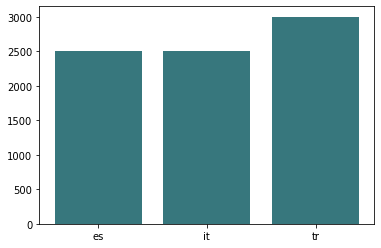

In [0]:
from collections import Counter

data = pd.read_csv("validation.csv")
freqs = Counter(data.lang)
print(freqs)
xvals = range(len(freqs.values()))
plt.bar(xvals, freqs.values() , color='#37777D')
plt.xticks(xvals, freqs.keys())
plt.show() 

Pretrained *DistilBERT*

In [17]:
input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")

embed = transformer.weights[0].numpy()
pretrained_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(np.shape(embed)[0], np.shape(embed)[1],
                      input_length=MAX_LEN, weights=[embed],
                      trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE)),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

ValueError: ignored

In [0]:
pretrained_model.compile(tf.keras.optimizers.Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [0]:
history = pretrained_model.fit(train, epochs=EPOCHS,
                        steps_per_epoch=BATCH_SIZE, callbacks=get_callbacks("pretrained_distilbert_log.csv"),
                    validation_data=valid)

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.4206 - accuracy: 0.8896
 ROC-AUC - epoch: 1 - score: 0.515492
32/32 [==============================] - 124s 4s/step - loss: 0.4206 - accuracy: 0.8896 - val_loss: 0.4316 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 0.2946 - accuracy: 0.9121
 ROC-AUC - epoch: 2 - score: 0.536517
32/32 [==============================] - 124s 4s/step - loss: 0.2946 - accuracy: 0.9121 - val_loss: 0.4621 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 0.3210 - accuracy: 0.8916
 ROC-AUC - epoch: 3 - score: 0.574869
32/32 [==============================] - 124s 4s/step - loss: 0.3210 - accuracy: 0.8916 - val_loss: 0.4259 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.9014
 ROC-AUC - epoch: 4 - score: 0.592601
32/32 [==============================] - 12

Pretrained DistilBert with *attention*

In [0]:
embedding = tf.keras.layers.Embedding(np.shape(embed)[0], np.shape(embed)[1],
                      input_length=MAX_LEN, weights=[embed],
                      trainable=False)(input_word_ids)
bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE))(embedding)
attention = tf.keras.layers.Attention()([bi_lstm, bi_lstm])
dense1 = tf.keras.layers.Dense(BATCH_SIZE, activation='relu')(attention)
dense2 = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)

pretrained_with_attn = tf.keras.Model(inputs=input_word_ids, outputs=dense2)
# pretrained_with_attn.add(tf.keras.layers.Attention())


In [0]:
pretrained_with_attn.compile(tf.keras.optimizers.Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [0]:
history = pretrained_with_attn.fit(train, epochs=EPOCHS,
                        steps_per_epoch=BATCH_SIZE, callbacks=get_callbacks("pretrained_with_attn.csv"),
                    validation_data=valid)

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3952 - accuracy: 0.8926
 ROC-AUC - epoch: 1 - score: 0.496610
32/32 [==============================] - 123s 4s/step - loss: 0.3952 - accuracy: 0.8926 - val_loss: 0.4348 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.9014
 ROC-AUC - epoch: 2 - score: 0.496674
32/32 [==============================] - 122s 4s/step - loss: 0.3256 - accuracy: 0.9014 - val_loss: 0.4399 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.8916
 ROC-AUC - epoch: 3 - score: 0.498411
32/32 [==============================] - 122s 4s/step - loss: 0.3439 - accuracy: 0.8916 - val_loss: 0.4349 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss: 0.2987 - accuracy: 0.9121
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.



Scratch with Attention

In [0]:
embedding = tf.keras.layers.Embedding(np.shape(embed)[0], np.shape(embed)[1],
                      input_length=MAX_LEN)(input_word_ids)
bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE))(embedding)
attention = tf.keras.layers.Attention()([bi_lstm, bi_lstm])
dense1 = tf.keras.layers.Dense(BATCH_SIZE, activation='relu')(attention)
dense2 = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)
scratch_with_attn = tf.keras.Model(inputs=input_word_ids, outputs=dense2)

In [0]:
scratch_with_attn.compile(tf.keras.optimizers.Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [0]:
history = scratch_with_attn.fit(train, epochs=EPOCHS,
                        steps_per_epoch=BATCH_SIZE, callbacks=get_callbacks("scratch_with_attn.csv"),
                    validation_data=valid)

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.4208 - accuracy: 0.8721
 ROC-AUC - epoch: 1 - score: 0.521324
32/32 [==============================] - 169s 5s/step - loss: 0.4208 - accuracy: 0.8721 - val_loss: 0.4440 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.9062
 ROC-AUC - epoch: 2 - score: 0.534601
32/32 [==============================] - 170s 5s/step - loss: 0.3113 - accuracy: 0.9062 - val_loss: 0.4391 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 0.3608 - accuracy: 0.8838
 ROC-AUC - epoch: 3 - score: 0.533383
32/32 [==============================] - 171s 5s/step - loss: 0.3608 - accuracy: 0.8838 - val_loss: 0.4351 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss: 0.2849 - accuracy: 0.9180
 ROC-AUC - epoch: 4 - score: 0.536298
32/32 [==============================] - 17

Pretrained DistilBERT with >1 layers of LSTM

2 Layers

In [0]:
input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")

embed = transformer.weights[0].numpy()
pretrained_model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(np.shape(embed)[0], np.shape(embed)[1],
                      input_length=MAX_LEN, weights=[embed],
                      trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE)),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [0]:
pretrained_model_2.compile(tf.keras.optimizers.Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [59]:
history = pretrained_model_2.fit(train, epochs=20,
                        steps_per_epoch=BATCH_SIZE, callbacks=get_callbacks("pretrained_distilbert_2_log.csv"),
                    validation_data=valid)

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.1993 - accuracy: 0.9268

ValueError: ignored

4 Layers

In [0]:
input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")

embed = transformer.weights[0].numpy()
pretrained_model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(np.shape(embed)[0], np.shape(embed)[1],
                      input_length=MAX_LEN, weights=[embed],
                      trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE)),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [0]:
pretrained_model_4.compile(tf.keras.optimizers.Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [61]:
history = pretrained_model_4.fit(train, epochs=20,
                        steps_per_epoch=BATCH_SIZE, callbacks=get_callbacks("pretrained_distilbert_4_log.csv"),
                    validation_data=valid)

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9385
 ROC-AUC - epoch: 1 - score: 0.656809
32/32 [==============================] - 279s 9s/step - loss: 0.1634 - accuracy: 0.9385 - val_loss: 0.7636 - val_accuracy: 0.5185 - lr: 2.7000e-05
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9414
 ROC-AUC - epoch: 2 - score: 0.656191
32/32 [==============================] - 279s 9s/step - loss: 0.1717 - accuracy: 0.9414 - val_loss: 0.7567 - val_accuracy: 0.5224 - lr: 2.7000e-05
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9385
 ROC-AUC - epoch: 3 - score: 0.655983
32/32 [==============================] - 281s 9s/step - loss: 0.1618 - accuracy: 0.9385 - val_loss: 0.7283 - val_accuracy: 0.5449 - lr: 2.7000e-05
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.9326
 ROC-AUC - epoch: 4 - score: 0.655489
32/32 [========================

Error Analysis Data

In [0]:
y_pred = pretrained_model_2.predict(x_valid)

In [53]:
print(y_pred)

[[0.20209381]
 [0.0956395 ]
 [0.02202642]
 ...
 [0.80078626]
 [0.05597797]
 [0.22816327]]


In [0]:
def get_label(prob):
  if prob < 0.5:
    return 0
  return 1

In [55]:
valid_raw = pd.read_csv("validation.csv")
x = valid_raw.comment_text.astype(str)
lang = valid_raw.lang.astype(str)
print(lang)

0       es
1       it
2       es
3       tr
4       tr
        ..
7995    it
7996    es
7997    tr
7998    es
7999    it
Name: lang, Length: 8000, dtype: object


In [58]:
mislabeled = {'es': 0, 'tr': 0, 'it': 0}
for i in range(len(y_pred)):
  pred_label = get_label(y_pred[i])
  if pred_label != y_valid[i]:
    print("expected " + str(y_valid[i]) + "; got " + str(pred_label))
    print("x: " + str(x[i]))
    mislabeled[lang[i]] += 1

print(mislabeled)

Streaming output truncated to the last 5000 lines.
expected 0; got 1
x: onlara hoşgeldin demek istemiştim imzamı atmadığımdan dolayı 2. bir kez mesaj değiştirmek zorunda kaldım hatam varsa özür dilerim. İremucar  Rica ederim, özür gerektiren bir durum yok, sadece neden başka kullanıcıların mesaj sayfalarından kopyala-yapıştır yaparak hoşgeldin mesajı yolladığınızı merak etmiştim. Yeni kullanıcılara hoşgeldin mesajı yollamak için en kestirme yol, mesaj sayfalarına yazmak, hepsi bu. Teşekkürler, kolay gelsin. M. M. 
expected 0; got 1
x: Scusa, ma che diavolo c entra la grafia?? Stiamo parlando di pronuncia!! Nessuno ha mai detto che la grafia sia cambiata!! In tutte le versioni dell anime e dei videogiochi la grafia è sempre stata  Meowth  (così come lo è adesso, perchè dovrebbe cambiare?) e la pronuncia è sempre stata  MIAO . Ma poi, hai letto bene quello che ti ha scritto Syrio, riguardo alla pronuncia del verso dei gatti??Mars2 (msg) 
expected 0; got 1
x: Sevgili Superyetkin; 3 tane p